# Boston Housing Prices

The objective of this workbook is to generate an optimal model based on statistical analysis with the tools available to estimate the best selling price for the client's home. Additional information on the Boston Housing dataset can be found [`here`](https://archive.ics.uci.edu/ml/datasets/Housing).

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [11]:
import os
import numpy as np
import pylab as pl
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd

#Libraries from Sci-kit Learn
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
#Polynomial Regression:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Explore Data

In [5]:
#Load boston dataset
boston = datasets.load_boston()

#Values
housing_prices = boston.target #target values
housing_features = boston.data #attributes values

#Store in DataFrame
attributes = boston.feature_names #feature names
df_data = pd.DataFrame(housing_features, columns = attributes)
df_target = pd.DataFrame(housing_prices, columns =['MEDV'])
df_boston = pd.concat([df_data, df_target,], axis = 1) #concat data/target
print boston.DESCR

print "*****************************"
print "Summary\n"
feats = df_boston.shape[1]
obs = df_boston.shape[0]
print "Number of Housing Features: ", feats
print "Number of Houses: ", obs


Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [4]:
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
df_boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Statistical Analysis and Data Exploration

####  Of the available features for a given home, which are significant and what do they measure?

- First, a histogram is generated to show the distribution of median housing prices in the greater Boston area. The scatter plots consists of the median value of homes (`MEDV`) vs the 12 different features. Based on the results, `CRIM`, `RM`, and `LSAT` show a strong linear correlation for predicting the `MEDV`. For instance, as the number of rooms per house increases, so does the housing price. Several other plots are generated to explore relationships among the input features.

In [6]:
def histogram():
    X,y = housing_features, housing_prices
    pl.figure(figsize=(8,6))
    pl.hist(y, bins =20, color = 'blue',alpha=0.5)
    pl.suptitle('Boston Housing Prices', fontsize = 18)
    pl.xlabel('Housing Prices [$10k]', fontsize = 16)
    pl.ylabel('Frequency', fontsize = 16)
    pl.show()

In [7]:
def scatter_plots():
    pl.figure()
    fig,axes = pl.subplots(4, 4, figsize=(14,18))
    fig.subplots_adjust(wspace=.4, hspace=.4)
    img_index = 0
    for i in range(boston.feature_names.size):
        row, col = i // 4, i % 4
        axes[row][col].scatter(boston.data[:,i],boston.target)
        axes[row][col].set_title(boston.feature_names[i] + ' and MEDV')
        axes[row][col].set_xlabel(boston.feature_names[i])
        axes[row][col].set_ylabel('MEDV')
    pl.show()

In [8]:
def corrplot():
    fig, ax = pl.subplots(figsize=(10,10))
    pl.title("Correlation Plot",fontsize=16)
    sns.corrplot(df_boston)

In [9]:
# Calculate some Boston housing statistics:
def explore_city_data():
    number_houses = housing_features.shape[0] # size of data
    number_features = housing_features.shape[1] # number of features
    min_price = np.min(housing_prices) # minimum price
    max_price = np.max(housing_prices) # maximum price
    mean_price = np.mean(housing_prices) # mean price
    median_price = np.median(housing_prices)# median price
    std_price = np.std(housing_prices)# standard deviation
    
    print "Number of houses:", number_houses
    print "Number of features:", number_features
    print "Minimum Housing Price: ${:,.2f}".format(min_price)
    print "Maximum Housing Price: ${:,.2f}".format(max_price)
    print "Mean Housing Price: ${:,.2f}".format(mean_price)
    print "Median Housing Price: ${:,.2f}".format(median_price)
    print "Standard Deviation: ${:,.2f}".format(std_price)

In [131]:
def plot1():
    x = 'CRIM'
    y = 'LSTAT'
    x_label, y_label = x,y
    title = x + ' and '+ y
    create_plot(x,y,x_label,y_label,title)
    
def plot2():
    x = 'AGE'
    y = 'RM'
    x_label, y_label = x,y
    title = x + ' and '+ y
    create_plot(x,y,x_label,y_label,title)

def plot3():
    x = 'PTRATIO'
    y = 'TAX'
    x_label, y_label = x,y
    title = x + ' and '+ y
    create_plot(x,y,x_label,y_label,title)

def create_plot(x,y,x_label,y_label,title):
    hue = df_target
    df = df_data
    markerSize = df_target['MEDV']*6
    g = sns.lmplot(x=x,y=y,data=df,
               scatter_kws={'s':markerSize,'alpha':0.5,'linewidths':1,'edgecolor':'w','color':'g'},
                   size=4.5, aspect=1.1)
    g.set_xlabels(x_label, size = 12)
    g.set_ylabels(y_label, size = 12)
    axes = g.axes
    sns.plt.title(title,fontsize=16)

***Statistics***

Number of houses: 506
Number of features: 13
Minimum Housing Price: $5.00
Maximum Housing Price: $50.00
Mean Housing Price: $22.53
Median Housing Price: $21.20
Standard Deviation: $9.19


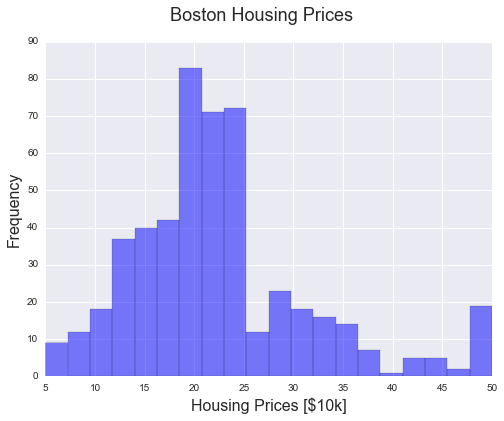

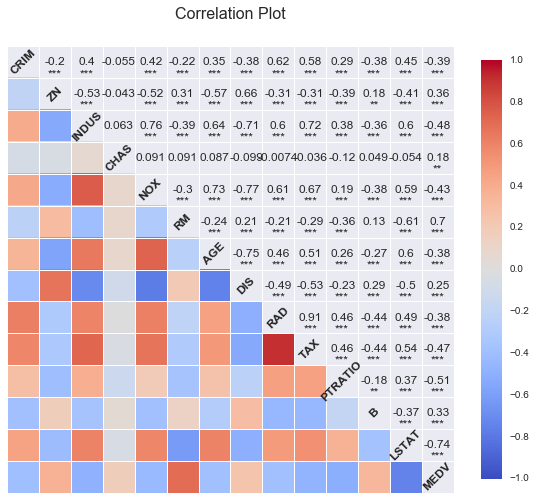

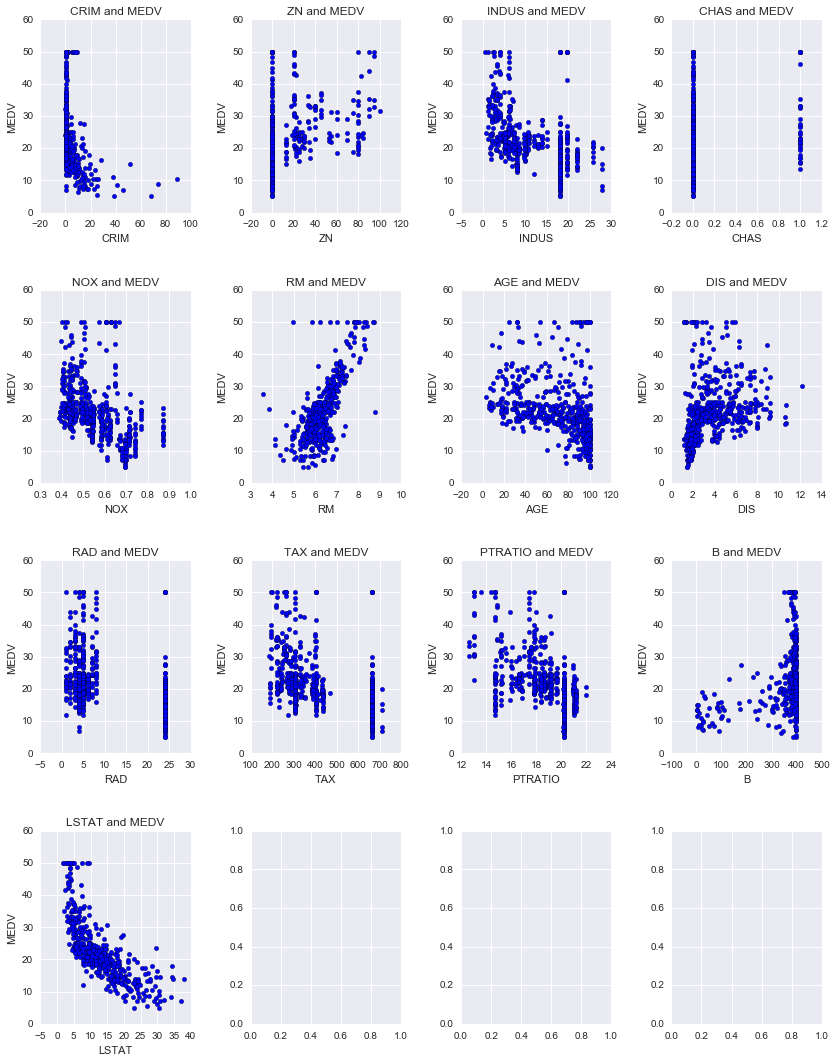


***Scatter Plots (Features)***


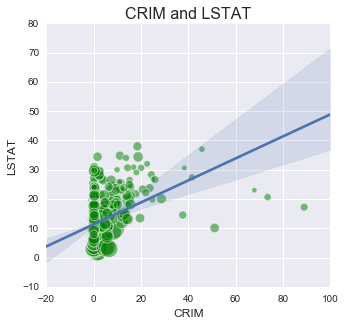

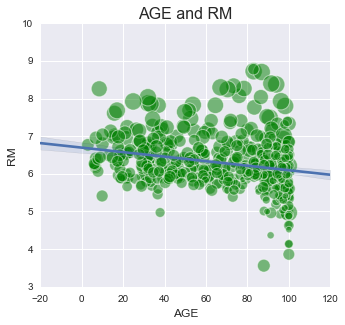

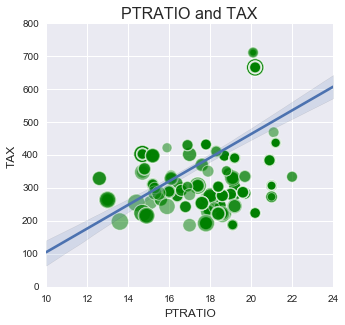

In [133]:
if __name__ == "__main__":   
    print "***Statistics***\n"
    explore_city_data()
    histogram()
    corrplot()
    scatter_plots()
    print "\n***Scatter Plots (Features)***"
    plot1()
    plot2()
    plot3()


### Training and Testing Data

#### Why split the dataset into training and testing subsets?

- Splitting the data into training and testing provides a measurement on how well the model will perform on out-of-sample data. Ideally, you want to perform a test on the dataset in which the algorithm has not seen in order to exclude any memorization. From there, you can then determine whether the algorithm works well with the out-of-sample data. A method of splitting the data using [sklearn.cross_validation.train_test_split()](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function allows the sample set to be randomly shuffled and then assigned `70%` as training and the remaining `30%` as the testing set. For this project, out of the `506` sampled houses, `354` are randomly selected and classified as the training set and the model is tested on `152` of the houses. 

In [19]:
def split_data():
    # Get the features and labels from the Boston housing data
    X, y = boston.data, boston.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=None)
    #print "X_training:", X_train.shape
    #print "X_test:", X_test.shape 
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data()

### Performance Metric:

#### Which performance metric below is most appropriate for predicting housing prices and analyzing error? Why?


- Accuracy, Precision, Recall, F1 score, Mean Squared Error (MSE), and Mean Absolute Error (MAE)


- Being a regression problem and not classification, the metric used to evaluate the performance of the predicting variable (housing price) is the [mean_squared_error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html), which takes all of the errors, the vertical distance from the observation to the regession line,squares  them, then finds the average. The MSE will heavily penalize outliers as oppose to the [mean absolute error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html),which takes all the errors, get the absolute values of them, and find the average.. When selecting betweeen the metrics, the objective is the minimize the error, which is why it is better to consider the MSE in the model. The two figures below dipicts the difference between the MSE (left) and the MAE (right) at a given depth `5`; it can be observed the error is minimized more for the MSE as opposed to the MAE. Furthermore, the machine learning algorithm for this project is [sklearn.tree.DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), therefore MSE is the valid peformance metric input for determining a split when constructing this model. 

 Mean Squarred Error             |  Mean Absolute Error  
:-------------------------:|:-------------------------: 
![](Images/learning_curve_5.png) | ![](Images/learning_curve_mae_5.png) 

In [90]:
def performance_metric(label, prediction):
    """Calculates and returns the appropriate error performance metric."""
    #mae = mean_absolute_error(label, prediction)
    mse = mean_squared_error(label, prediction)
    return mse

## Simple Linear Regression

Equation of Best Fit Line:
Y = [[ 9.01217996]]x + [-34.29222878]

Mean Square Error: 0.3866

Variance: 0.4962

Predicted Housing Price (1000$):
[[ 1.76]]


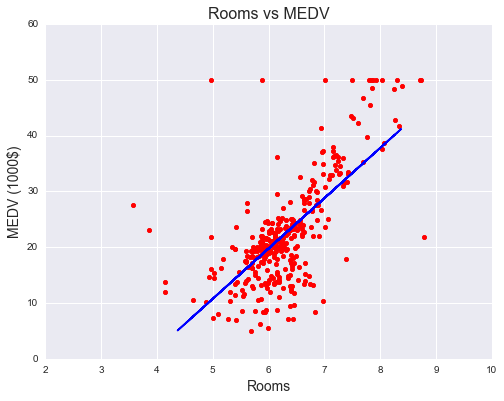

In [14]:
def linear_reg(x_train,x_test,y_train,y_test,feat_val):
    # Create Linear Regression Object
    reg = linear_model.LinearRegression()

    # Train the model using the training sets 
    x_train = np.array([x_train]).T 
    y_train = np.array([y_train]).T
    
    x_test = np.array([x_test]).T 
    y_test = np.array([y_test]).T
    
    fit = reg.fit(x_train,y_train)
    pred = reg.predict(x_test)

    print "Equation of Best Fit Line:"
    print "Y = %sx + %s" % (reg.coef_,reg.intercept_)
    
    print "\nMean Square Error: %s" % (mean_square_error(pred,y_test))
    print "\nVariance: %s" % (variance(reg,x_test,y_test))
   
    print "\nPredicted Housing Price (1000$):"
    print np.round(reg.coef_*feat_val + reg.intercept_,2)
    
    plot_linreg(x_train,x_test,y_train,pred)
    
def mean_square_error(pred,y_test):
    mse = round(np.mean(pred-y_test)**2,4)
    return mse

def variance(reg,x_test,y_test):
    # Explained variance score: 1 is perfect prediction
    var = round(reg.score(x_test,y_test),4)
    return var

def plot_linreg(x_train,x_test,y_train,pred):
    fig = pl.figure(figsize=(8,6))
    pl.scatter(x_train, y_train, color="red", marker="o")
    pl.plot(x_test,pred,color='blue')
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x_train,y_train, color="red", marker="o")
    ax.set_ylabel('MEDV (1000$)', fontsize=14)
    ax.set_xlabel('Rooms',fontsize=14)
    ax.set_title('Rooms vs MEDV', fontsize=16)
    ax.set_xlim(2,10)
    ax.set_ylim(0,60)
    pl.show()
    
def main():
    #x_train and x_test for feature of interest
    x_train = []
    x_test = []  
    for item in X_train:
        x_train.append(item[5]) #crime (Note: Enter any feature index here)
    for item in X_test:
        x_test.append(item[5]) #crime (Note: Enter any feature index here)
    
    '''Enter Feature Value'''
    feat_val = 4
    linear_reg(x_train,x_test,y_train,y_test,feat_val)


if __name__ == "__main__":
    main()

### Polynomial Regression

In [ ]:
def poly_reg(x_train,y_train,x_test,y_test):
    for d in [2]:
        poly = PolynomialFeatures(degree=d)
        X_ = poly.fit_transform(x_train)
        pred = poly.fit_transform(x_test)
        poly_plot(x_train,y_train,x_test,y_test,pred)
        
def poly_plot(x_train,y_train,x_test,y_test,pred):
    fig = pl.figure(figsize=(8,6))
    pl.plot(x_test,pred,color='blue')
    pl.scatter(x_train,y_train,color='purple',marker='o')
    pl.xlabel('LSTAT')
    pl.ylabel('MEDV (1000$)',fontsize=14)
    pl.title('LSTAT vs MEDV',fontsize= 16)
    pl.show()

def main():
    x_train = []
    x_test = []
    for item in X_train:
        x_train.append(item[12]) # LSTAT % lower status of the population
    for item in X_test:
        x_test.append(item[12])
    poly_reg(x_train,y_train,x_test,y_test)

if __name__ == "__main__":
    main()
    

### Multiple Linear Regression

In [91]:
def multiple_reg(X_train,X_test,y_train,y_test):
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    df = pd.DataFrame(zip(attributes,reg.coef_),columns=['Features','Coeff'])
    print df
    print '\nR-Squared: %s\n' % (round(reg.score(X_train,y_train),3))
    
    '''Predict Housing Price:'''
    pred = reg.predict(X_test)
    df_pred = pd.DataFrame({'Observed':y_test,'Predicted':pred})
    print df_pred.head()
    mse = performance_metric(y_test, pred)
    print "\nMean Squared Error: %s" % (round(mse,3))

def main():
    multiple_reg(X_train,X_test,y_train,y_test)

if __name__ == "__main__":
    main()

   Features      Coeff
0      CRIM  -0.110130
1        ZN   0.050912
2     INDUS   0.048238
3      CHAS   2.667673
4       NOX -23.177125
5        RM   3.353665
6       AGE   0.015792
7       DIS  -1.638062
8       RAD   0.357684
9       TAX  -0.012981
10  PTRATIO  -0.967413
11        B   0.005115
12    LSTAT  -0.627249

R-Squared: 0.724

   Observed  Predicted
0      17.7  20.316933
1      23.2  23.058399
2       8.4   4.528247
3       8.8   3.406594
4      50.0  40.911143

Mean Squared Error: 17.617


## Regression Tree

Decision Trees are a non-parametric supervised learning method and can be used for regression. The here goal is to create a model that predicts the value of the Boston housing prices by learning simple decision rules inferred from the data features. The following blocks consists of code utilized to construct the learning curves, model complexity, and fitting the model.

### Learning Curve

Decision Tree with Max Depth: 
5


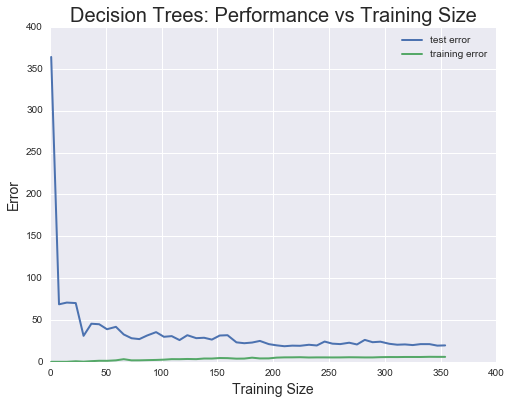

In [30]:
depth = 5
def learning_curve(depth, X_train, y_train, X_test, y_test):
    """Calculate the performance of the model after a set of training data."""

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.round(np.linspace(1, len(X_train), 50))
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    print "Decision Tree with Max Depth: "
    print (depth)

    for i, s in enumerate(sizes):

        # Create and fit the decision tree regressor model
        regressor = DecisionTreeRegressor(max_depth=depth)
        regressor.fit(X_train[:s], y_train[:s])

        # Find the performance on the training and testing set
        train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))


    # Plot learning curve graph
    learning_curve_graph(sizes, train_err, test_err)


def learning_curve_graph(sizes, train_err, test_err):
    """Plot training and test error as a function of the training size."""
    pl.figure()
    pl.figure(figsize=(8,6))
    pl.title('Decision Trees: Performance vs Training Size', fontsize = 20)
    pl.plot(sizes, test_err, lw=2, label = 'test error')
    pl.plot(sizes, train_err, lw=2, label = 'training error')
    pl.legend()
    pl.xlabel('Training Size', fontsize = 14)
    pl.ylabel('Error', fontsize =14)
    pl.show()
    
X_train, y_train, X_test, y_test = split_data()
learning_curve(depth, X_train, y_train, X_test, y_test)

####  When the model is using the full training set, does it suffer from high bias or high variance when the max depth is 1? What about when the max depth is 10?

- In the case of `max_depth` = `1`, the training error begins to significanlty increase as the training size increases and likewise, the error for the test error remains relatively high. Thus this situation where the `max_depth` of the decision tree is `1`, the model would be underfitting as the learning value is restricted to one level of the decision tree and does not allow the training set to learn data adequately. A low complexity decision tree results in high bias. For a `max_depth` = `10`, this would clearly illustrate a high variance and overfitting the data as shown below (right). The model has virtually memorized the training data but will not be expected to perform well with out-of-sample data.
 
Depth = 1                  | Depth = 10                  
:-------------------------:|:-------------------------: 
![](Images/learning_curve_1.png)  |![](Images/learning_curve_10.png)  


#### What is the max depth for the model? As the size of the training set increases, what happens to the training error? Describe what happens to the testing error.

- The learning curves for `max_depth` from 3-5 are shown below. As observed form the figures, the training error is virtually zero as the model has basically "memorized" the small training set. However, as more data is added to the model, the training error begins to increase. When the training size increases, error begins to increase and the high error translates to underfitting the data; likewise, the low training error would indicate overfitting the data. testing error is relatively high initially because it has not seen enough examples, but begins to decrease as more training examples are given. Based on the learning curve plots, it is concluded that the maximum depth for this model is `4`.

Max Depth = 3             |  Max Depth = 4  |    Max Depth = 5 |
:-------------------------:|:-------------------------: | :-----------------------
![](Images/learning_curve_3.png)  |  ![](Images/learning_curve_4.png) | ![](Images/learning_curve_5.png)

### Model Complexity

In [14]:
def model_complexity(X_train, y_train, X_test, y_test):
    """Calculate the performance of the model as model complexity increases."""

    print "Model Complexity: "

    # We will vary the depth of decision trees from 2 to 25
    max_depth = np.arange(1, 25)
    train_err = np.zeros(len(max_depth))
    test_err = np.zeros(len(max_depth))

    for i, d in enumerate(max_depth):
        # Setup a Decision Tree Regressor so that it learns a tree with depth d
        regressor = DecisionTreeRegressor(max_depth=d)

        # Fit the learner to the training data
        regressor.fit(X_train, y_train)

        # Find the performance on the training set
        train_err[i] = performance_metric(y_train, regressor.predict(X_train))

        # Find the performance on the testing set
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))

    # Plot the model complexity graph
    model_complexity_graph(max_depth, train_err, test_err)


def model_complexity_graph(max_depth, train_err, test_err):
    """Plot training and test error as a function of the depth of the decision tree learn."""
    pl.figure()
    pl.title('Decision Trees: Performance vs Max Depth', fontsize = 20)
    pl.plot(max_depth, test_err, lw=2, label = 'test error')
    pl.plot(max_depth, train_err, lw=2, label = 'training error')
    pl.legend()
    pl.xlabel('Max Depth',fontsize =14)
    pl.ylabel('Error', fontsize =14)
    pl.show()

### Fit Model 

#### What is the grid search algorithm and when is it applicable?

- A machine learning model can be fine-tuned by using the grid search algorithm, a hpyerparameter optimization technique. The performance of the model depends on the hyperparameters provided to the algorithm when training the model. It is desirable to find the right combination of the hyperparameters during training. [sklearn.grid_search.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) is an exhaustive search that trains and evaluates a model for all possible combination of hyperparameters that produce the best model. The `1-10`), and a scoring function so it is able to evaluate the parameter that performed the best (performance `metric mean_squared_error`). 

#### What is cross-validation and how is it performed on a model? Why would cross-validation be helpful when using grid search?
- A common occurance from machine learning algorithms is a degree of bias that can exist when random sampling the data and splitting the data between training and testing. To avoid sampling issues which can cause the training set to be too optimistic, cross-validation is a statistical approach that computes the average on multiple test sets. One of the most common iterators that performs the k-fold cross-validation is `KFolds` and the steps are as follows:


  1. Splits the data into K equal folds
  2. Uses one of the fold as the testing set and the remaining as the training set
  3. Trains and records the test set results
  4. The second and third steps are repeated using a different fold as the testing set each time
  5. Calculate the average and standard devation of all the k-folds
  6. Documentation can be found here:[sklearn.cross_validation.KFolds()](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html)


- The `train_test_split()` method can be very simple to perform however the downside is the training data is reduced by 30% when finding the best regression method. Using the default `GridSearchCV` parameters, the `cross-validation` generator is set to 3-fold CV. So for instance, the housing dataset consists of `506` observations per feature and if k=3, `169` observations would be in each fold. The initial iteration entails the first fold containing the testing data (`169 observations`) and the remaining folds (2-3) containing `337` observations, `168` each. In second iteration, the testing set is now fold #2 while fold #1 and fold #3 are the training set. We train K different models, with each time leaving out a single subset for measuring the cross-validation error. The final cross-validation error is calculated by taking the mean or median of the K models. The advantage of cross-validation provides a more accurate estimate of the out-of-sample accuracy and is more efficient as every observation is used for both training and testing as oppose to the train/test/split method.  

In [15]:
def fit_predict_model():

    # Get the features and labels from the Boston housing data
    
    X, y = boston.data, boston.target

    # Setup a Decision Tree Regressor
    
    regressor = DecisionTreeRegressor()
    
    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
    
    mse_scoring = make_scorer(mean_squared_error, greater_is_better=False)
    
    #using grid search to fine tune the Decision Tree Regressor and
    #obtain the parameters that generate the best training performance. 

    reg = GridSearchCV(regressor, parameters, scoring = mse_scoring)
    reg.fit(X,y)
    
    # Fit the learner to the training data to obtain the best parameter set
    print "Final Model: "
    print (reg.fit(X, y))    

    # Using the model to predict the output of a particular sample
    x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
    x = np.array(x)
    x = x.reshape(1, -1)
    y = reg.predict(x)
    
    print "Best Parameters: ", reg.best_params_
    print "Best Estimator:", reg.best_estimator_
    print "Grid Score:", reg.grid_scores_
    print "\n"
    print "House: " + str(x)
    print "\n"
    print "Predicted: " + str(y)
    
    #DataFrame of Client_Features
    #x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
    #pd.DataFrame(zip(boston.feature_names, x), columns = ['Features', 'Client_Features'])
    

### Run Regression Tree Model

Decision Tree with Max Depth: 
1


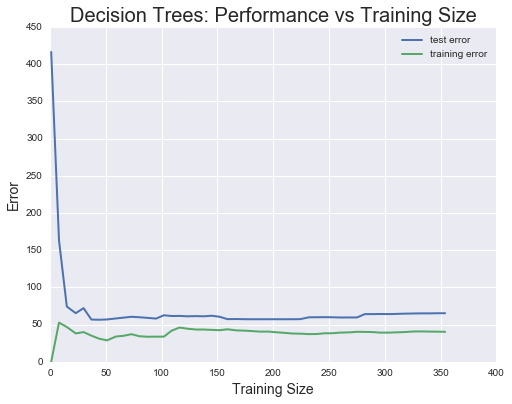

Decision Tree with Max Depth: 
2


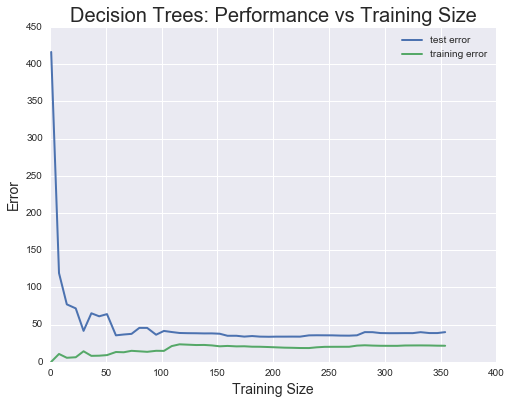

Decision Tree with Max Depth: 
3


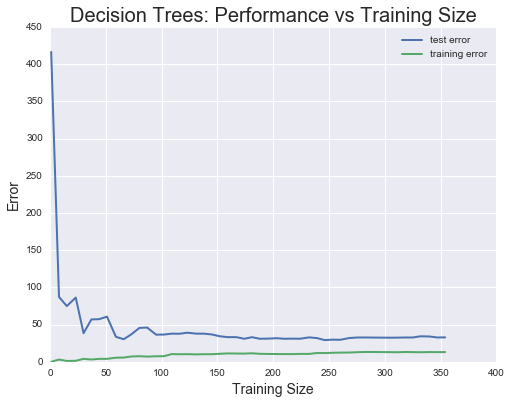

Decision Tree with Max Depth: 
4


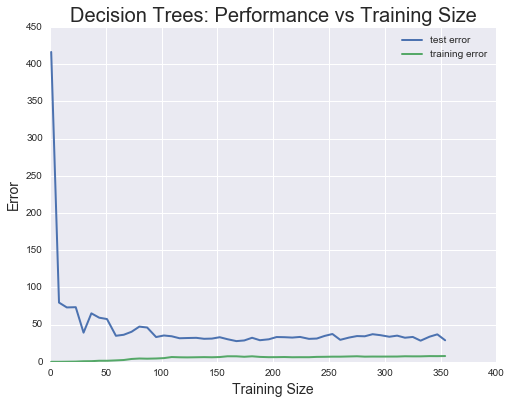

Decision Tree with Max Depth: 
5


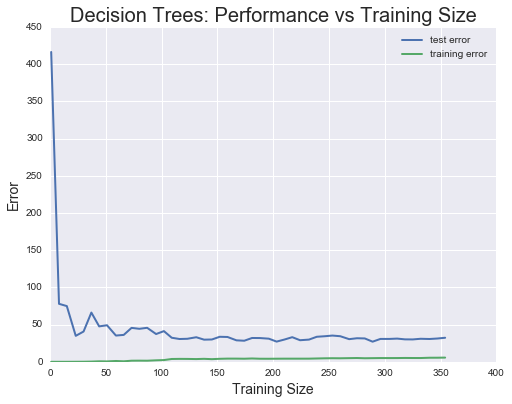

Decision Tree with Max Depth: 
6


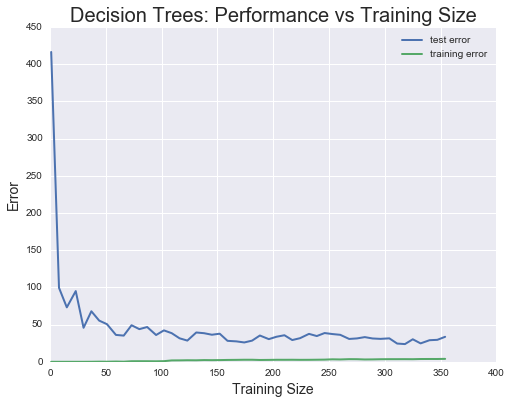

Decision Tree with Max Depth: 
7


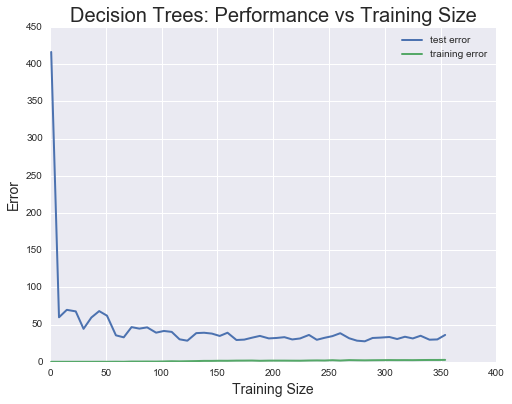

Decision Tree with Max Depth: 
8


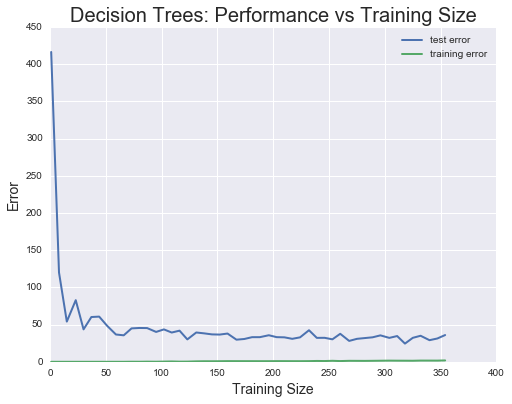

Decision Tree with Max Depth: 
9


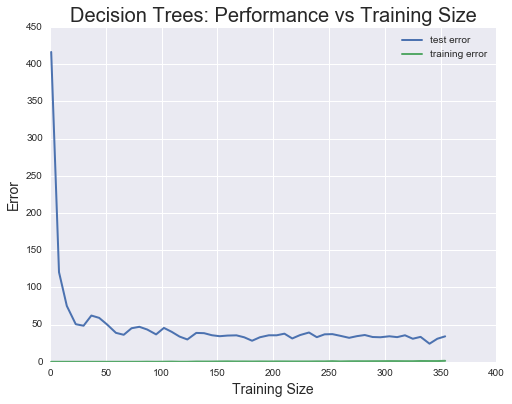

Decision Tree with Max Depth: 
10


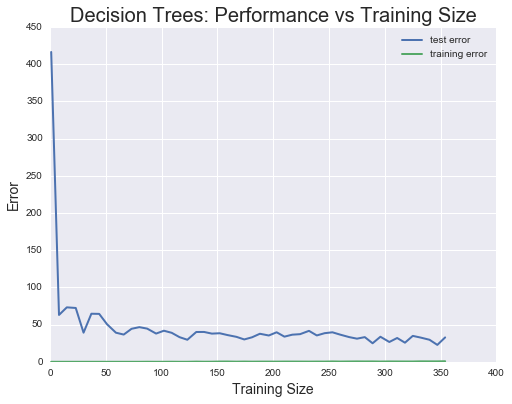

Model Complexity: 


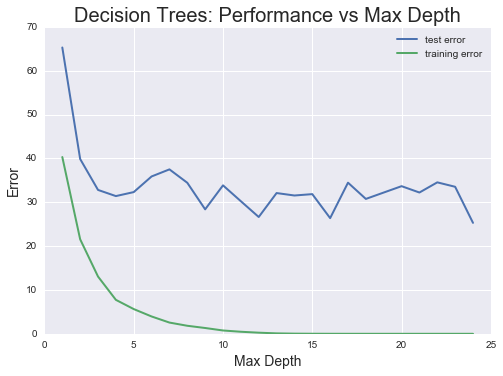

Final Model: 
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)
Best Parameters:  {'max_depth': 4}
Best Estimator: DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Grid Score: [mean: -68.08279, std: 25.52601, params: {'max_depth': 1}, mean: -46.72022, std: 21.02827, params: {'max_depth': 2}, mean:

In [16]:
def main():
    
    # Learning Curve Graphs
    max_depths = [1,2,3,4,5,6,7,8,9,10]
    for max_depth in max_depths:
        learning_curve(max_depth, X_train, y_train, X_test, y_test)
    
    # Model Complexity Graph
    model_complexity(X_train, y_train, X_test, y_test)

    #Tune and predict Model
    fit_predict_model()


if __name__ == "__main__":
    main()

#### From the model complexity graph, describe the training and testing errors as the max depth increases. Based on your interpretation of the graph, which max depth results in a model that best generalizes the dataset? Why?

- As the `max_depth` is increased, the training error begins to exponentially decline and approaches zero as the model becomes more complex. The testing error begins to differs from the training error near an `max_depth` = `4`, which best generalizes the dataset. At the instance where the model begins to behave too much like the training data then it might be observed that overfitting is occuring as the model does not perform well when testing and the error rates will begin to significanlty differ. A decrease in the training error implies that the model is becoming better at fitting the data; when the testing error plateaus and is no longer decreasing, additional knowledge is not gained on the out-of-sample data. If the error does not reduce any further during testing, then the complexity is increased for no reason and therefore overfitting occurs.
<p align="center">![](Images/Model.Complexity.png)</p>

#### Using grid search, what is the optimal max depth for your model? How does this result compare to your initial intuition?
- Based on the model complexity graph, the model that best generalizes the data is when `max_depth` = `4`. Calling the `grid.best_params_` from `GridSearchCV` confirms the maximum level to split the decision tree is `4`. 


### Tune the Optimal Model

In [17]:
def iterate_fit_predict():
    """.Make a prediction on housing data."""

    # Get the features and labels from the Boston housing data
    X, y = boston.data, boston.target

    # Setup a Decision Tree Regressor
    regressor = DecisionTreeRegressor()
  
    mse_scoring = make_scorer(mean_squared_error, greater_is_better=False)
    
    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
    
    reg = GridSearchCV(regressor, parameters, scoring = mse_scoring, cv=3)

    # Fit the learner to the training data to obtain the best parameter set
    reg.fit(X, y)

    # Use the model to predict the output of a particular sample
    x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
    x = np.array(x)
    x = x.reshape(1, -1)
    y = reg.predict(x)
    
    return (reg.best_params_['max_depth'], y[0])

Iteration: Fit and Predict Model
    (GridSearchCV Results)

In [18]:
Grid_Search_Results = []

for i in range(100):
    Grid_Search_Results.append(iterate_fit_predict())

Grid_Search= np.asarray(Grid_Search_Results)
Grid_Search_Results_Depth = np.asarray(Grid_Search.T[0], dtype=int)
Grid_Search_Results_Price = np.asarray(Grid_Search.T[1], dtype=float)

Histogram: Maximum Depth (iterations = 100)

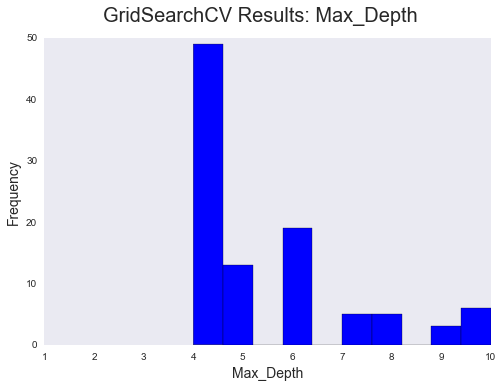

In [19]:
pl.hist(Grid_Search_Results_Depth, bins = 10, color = 'blue')
pl.suptitle("GridSearchCV Results: Max_Depth", fontsize = 20)
pl.xlabel("Max_Depth", fontsize = 14)
pl.ylabel("Frequency", fontsize = 14)
pl.xlim(1,10)
pl.grid()
pl.show()

Histogram: Predicted Housing Prices (iteraitons = 100)

### Discuss whether you would use this model or not to predict the selling price of future clients? homes in the Boston area.

- Being there is variability in the predicted price, which is actually expected since the code randomizes the data and therefore affects fitting the model to the data, multiple iterations of the model is desired in order to provide a conclusive prediction. Ideally, you would want to run the model multiple times and determine a range of values to that has the highest frequency of occurance and identify a central tendency based on the distribution for the `MEDV`. To do this, `1,000` iterations (randomly sampling each iteration, `cross-validation` =`3` ) were performed by using  `sklearn.GridSearchCV()` to determine the `max_depth` of the decision tree and the predicted housing price. Both results validate that the `max_depth` = `4` and the suggested value of the home is consistent around `$21,500`.  

Max_Depth                  | Predicted Prices            
:-------------------------:|:-------------------------: 
![](Images/Gridsearch_MaxDepth_Hist.png)  |![](Images/Gridsearch_Prices_Hist.png)   